In [1]:
import deepxde as dde
import numpy as np
# Backend tensorflow.compat.v1 or tensorflow
from deepxde.backend import tf
# Backend pytorch
# import torch
# Backend paddle
# import paddle
import matplotlib.pyplot as plt
Ctrue=2
C = dde.Variable(0.05)

def pde(x, y):  # wave equation
    dy_tt = dde.grad.hessian(y, x, i=1, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return dy_xx + dy_tt+C**2*y

def initial_pos(x):  # initial position
    return np.sin(np.pi * x[:, 0:1])

def initial_velo(x):  # initial velocity
    return 0.0


def boundary_left(x, on_boundary):  # boundary x=-1
    is_on_boundary_left = on_boundary and np.isclose(x[0], -1)
    return is_on_boundary_left

def boundary_right(x, on_boundary):  # boundary x=1
    is_on_boundary_right = on_boundary and np.isclose(x[0], 1)
    return is_on_boundary_right

def boundary_bottom(x, on_boundary):  # boundary t=-1
    is_on_boundary_bottom = on_boundary and np.isclose(x[1], -1)
    return is_on_boundary_bottom


def boundary_upper(x, on_boundary):  # boundary t=1
    is_on_boundary_upper = on_boundary and np.isclose(x[1], 1)
    return is_on_boundary_upper

def func(x):
    return 0.5*np.sin(Ctrue* x[:, 0:1]) * np.cos(Ctrue*x[:, 1:])


Using backend: tensorflow



In [2]:

#geom = dde.geometry.Interval(0, 1)
#timedomain = dde.geometry.TimeDomain(0, 2)
#geomtime = dde.geometry.GeometryXTime(geom, timedomain)

geom = dde.geometry.Rectangle(xmin=[-1, -1], xmax=[1, 1])


bc1 = dde.DirichletBC(geom, lambda x: 0, boundary_left)  #correct

bc2 = dde.DirichletBC(geom, lambda x: 0, boundary_right) #correct

bc3 = dde.DirichletBC(geom, lambda x: 0, boundary_bottom)  #correct

bc4 = dde.NeumannBC(geom, lambda x: 0, boundary_upper)  #correct


observe_x_1 = np.vstack((np.linspace(-1, 1, num=200), np.full((200), 1))).T
observe_x_2 = np.vstack((np.linspace(-1, 1, num=200), np.full((200), -1))).T
observe_x_3 = np.vstack((np.full((200), -1),np.linspace(-1, 1, num=200))).T
observe_x_4 = np.vstack((np.full((200), 1),np.linspace(-1, 1, num=200))).T


observe_x_initial = np.random.uniform((-1, -1), (1, 1), (1000, 2))
observe_x_5=np.array([a for a in observe_x_initial if -1<a[0]<1 and -1<a[1]<1])
observe_x=np.array(list(observe_x_1)+list(observe_x_2)+list(observe_x_3)+list(observe_x_4)+list(observe_x_5))

observe_y = dde.icbc.PointSetBC(observe_x_5, func(observe_x_5), component=0)

data = dde.data.PDE(
    geom,
    pde,
    [bc1, bc2, bc3, bc4, observe_y],
     num_domain=0,
    num_boundary=0, 
    train_distribution="uniform", anchors=observe_x,
    num_test=1000, solution=func
)


Compiling model...
'compile' took 0.001603 s

Training model...



d:\setup_position_1\anaconda\envs\DeepXDE\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Cause: could not parse the source code of <function <lambda> at 0x0000022A2182F8B0>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x0000022A2182F8B0>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function <lambda> at 0x0000022A2182FC10>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], o

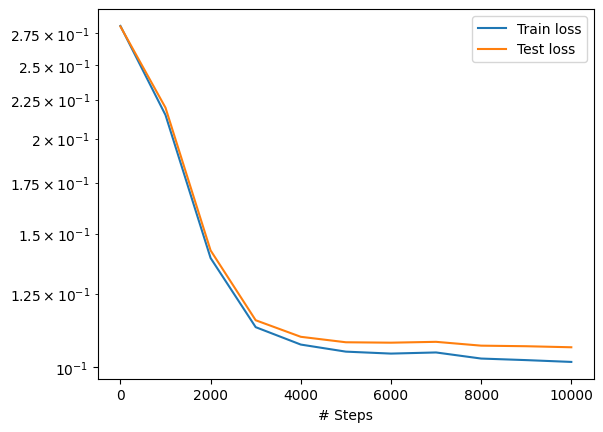

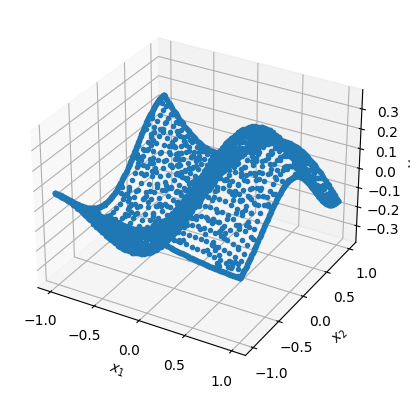

In [3]:



net = dde.maps.FNN([2] + [50] * 4 + [1], "tanh", "Glorot uniform")  #the input layer has size 2, there are 4 hidden layers of size 50 and one output layer of size 1

#Activation function is tanh; the weights are initially chosen to be uniformly distributed according to Glorat distribution


model = dde.Model(data, net)
#model.train_state.set_data_train( X_train=observe_final, y_train=func(observe_final), train_aux_vars=None)

model.compile("adam", lr=0.001,loss_weights=[1,1,1,1,1,6], external_trainable_variables=C)
filname = "variables.dat"
variable = dde.callbacks.VariableValue(C, period=1000, filename=filname)


losshistory, train_state=model.train(iterations=10000, callbacks=[variable])

#model.compile("L-BFGS-B")

#model.compile("L-BFGS-B", external_trainable_variables=C)
#variable1 = dde.callbacks.VariableValue(C, period=100, filename=filname)
#losshistory, train_state = model.train(epochs=800, callbacks=[variable])

dde.saveplot(
    losshistory, train_state, issave=True, isplot=True
)
#observe_x = np.vstack((np.linspace(-1, 1, num=100), np.full((100), 1))).T
#observe_y = dde.icbc.PointSetBC(observe_x, func(observe_x), component=0)


In [4]:
C

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=3.219257>

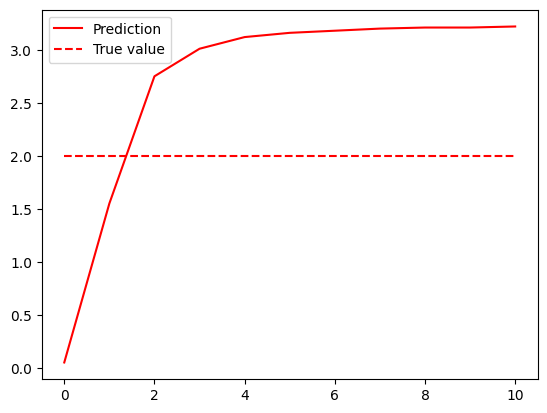

NameError: name 'numepochs' is not defined

In [6]:

import re
lines = open(filname, "r").readlines()
# read output data in fnamevar
Chat = np.array(
    [
        np.fromstring(
            min(re.findall(re.escape("[") + "(.*?)" + re.escape("]"), line), key=len),
            sep=",",
        )
        for line in lines
    ]
)
l, c = Chat.shape
plt.plot(range(l), Chat[:, 0], "r-", label="Prediction")
#plt.semilogy(range(0, l * 100, 100), Chat[:, 1], "k-")
plt.plot(range(l), np.ones(Chat[:, 0].shape) * Ctrue, "r--", label="True value")
#plt.semilogy(range(0, l * 100, 100), np.ones(Chat[:, 1].shape) * C2true, "k--")
#plt.legend(["C1hat", "C2hat", "True C1", "True C2"], loc="right")
#plt.xlabel("Epochs")
#plt.title("Variables")
plt.legend()
plt.show()
#print(np.array(losshistory.loss_train).T[0])

np.arange(1,numepochs+1,1)
#plt.plot(np.arange(0,numepochs+1,1),np.array(losshistory.loss_train).T[0])
print(Chat[:, 0][-1])

#predicted_solution_training=np.ravel(model.predict(data.train_x_all)) 

#print(predicted_solution_training)

X = np.linspace(0, 1, 100)
t = np.linspace(0, 2, 200)

X_repeated = np.repeat(X, t.shape[0])
t_tiled = np.tile(t, X.shape[0])
XX = np.vstack((X_repeated, t_tiled)).T

state_predict = model.predict(XX).T
state_predict_M = state_predict.reshape((100, 200)).T

Xx, Tt = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 2, 200))

fig = plt.figure()  # plot of predicted state
ax = plt.axes(projection="3d")
surf = ax.plot_surface(
    Xx, Tt, state_predict_M, cmap="hsv_r", linewidth=0, antialiased=False
)

ax.set_title("PINN state ")
ax.set_xlabel("$x$")
ax.set_ylabel("$t$")
fig.colorbar(surf, shrink=0.6, aspect=10)
plt.show()

import math

def explicit_state(x,t):
    return np.sin(math.pi*x)*np.cos(2*math.pi*t)

state_exact = explicit_state(Xx, Tt)  # computation of exact state

fig = plt.figure()  # plot of exact state
ax = plt.axes(projection="3d")
surf2 = ax.plot_surface(
    Xx, Tt, state_exact, cmap="hsv_r", linewidth=0, antialiased=False
)

ax.set_title("Exact state ")
ax.set_xlabel("$x$")
ax.set_ylabel("$t$")

fig.colorbar(surf2, shrink=0.6, aspect=10)

plt.show()

fig = plt.figure()  # plot of the difference between exact and PINN state
ax = plt.axes(projection="3d")
surf2 = ax.plot_surface(
    Xx, Tt, state_exact-state_predict_M, cmap="hsv_r", 
    linewidth=0, antialiased=False
)

ax.set_title("Difference of the exact and PINN state")
ax.set_xlabel("$x$")
ax.set_ylabel("$t$")

fig.colorbar(surf2, shrink=0.6, aspect=10)

plt.show()

print(observe_x.T[0])
print(observe_x.T[1])
print(model.predict(observe_x).T[0])

fig = plt.figure()  # plot of the difference between exact and PINN state
ax = plt.axes(projection="3d")
surf2 = ax.scatter(observe_x.T[0], observe_x.T[1], model.predict(observe_x).T[0], marker="o")

ax.set_title("PINN prediction of the training set")
ax.set_xlabel("$x$")
ax.set_ylabel("$t$")

#fig.colorbar(surf2, shrink=0.6, aspect=10)

plt.show()

fig = plt.figure()  # plot of the difference between exact and PINN state
ax = plt.axes(projection="3d")
surf2 = ax.scatter(observe_x.T[0], observe_x.T[1], explicit_state(observe_x.T[0], observe_x.T[1]))

ax.set_title("True solution of the training set")
ax.set_xlabel("$x$")
ax.set_ylabel("$t$")

#fig.colorbar(surf2, shrink=0.6, aspect=10)

plt.show()

fig = plt.figure()  # plot of the difference between exact and PINN state
ax = plt.axes(projection="3d")
surf2 = ax.scatter(observe_x.T[0], observe_x.T[1], explicit_state(observe_x.T[0], observe_x.T[1])-model.predict(observe_x).T[0])

ax.set_title("Difference of the true and predicted solution of the training set")
ax.set_xlabel("$x$")
ax.set_ylabel("$t$")

#fig.colorbar(surf2, shrink=0.6, aspect=10)

plt.show()
print("Difference of the true and predicted solution of the training set are {}".format(explicit_state(observe_x.T[0], observe_x.T[1])-model.predict(observe_x).T[0]))




fig = plt.figure()  # plot of the difference between exact and PINN state
ax = plt.axes(projection="3d")
surf2 = ax.scatter([0,1,2,3,4], [0,1,2,3,4], [3,4,5,6,8])

ax.set_title("Difference of the true and predicted solution of the training set")
ax.set_xlabel("$x$")
ax.set_ylabel("$t$")

#fig.colorbar(surf2, shrink=0.6, aspect=10)

plt.show()






a=np.arange(0,60100,1000)

plt.plot(a,np.array(losshistory.loss_train).T[0], label=r'$L_{PDE}$', linestyle="-" )
plt.plot(a,np.array(losshistory.loss_train).T[1], label=r"$L_{x=0}$",  linestyle="-")
plt.plot(a,np.array(losshistory.loss_train).T[2], label=r"$L_{x=1}$",  linestyle="-")
plt.plot(a,np.array(losshistory.loss_train).T[3], label=r"${L_{t=0_{2}}}$", linestyle="-")
plt.plot(a,np.array(losshistory.loss_train).T[4], label=r"${L_{t=0_{1}}}$",  linestyle="-")
plt.plot(a,np.array(losshistory.loss_train).T[5], label=r"$6·L_{train}$", linestyle="-")

plt.xlabel("Number of epochs")
plt.ylabel("Error")
plt.legend()